# Data Research

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import plotly.express as px
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy import stats
import xgboost as xgb
import lightgbm as lgb

pd.set_option('max_columns', None)
sns.set_theme(palette=sns.color_palette("Set2"), rc={'figure.figsize':(15,6)})

## Feature description

In [2]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
train.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## SalePrice

In [3]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

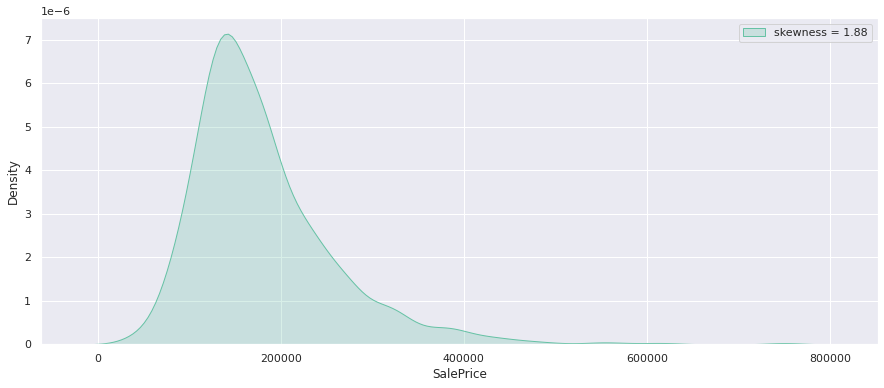

In [4]:
fig, axes = plt.subplots()
sns.kdeplot(x=train['SalePrice'], shade=True, ax=axes, label=f'skewness = {train["SalePrice"].skew():.2f}')
axes.legend()

## Correlation matrix

In [5]:
fig = px.imshow(img=train.corr())
fig.show()

The most correlated features are (>0.8):
* TotalBsmtSF and 1stFlrSF
* GarageArea and GarageCars
* YrBuilt and GarageYrBuilt
* TotRmsAbvGrd and GrLivArea

## Target correlations

In [6]:
train.corr().nlargest(10, columns='SalePrice')['SalePrice']

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

TotRmsAbvGrd, GarageArea, 1stFlrSF will be dropped beacause they are twins with their pairs discussed earlier

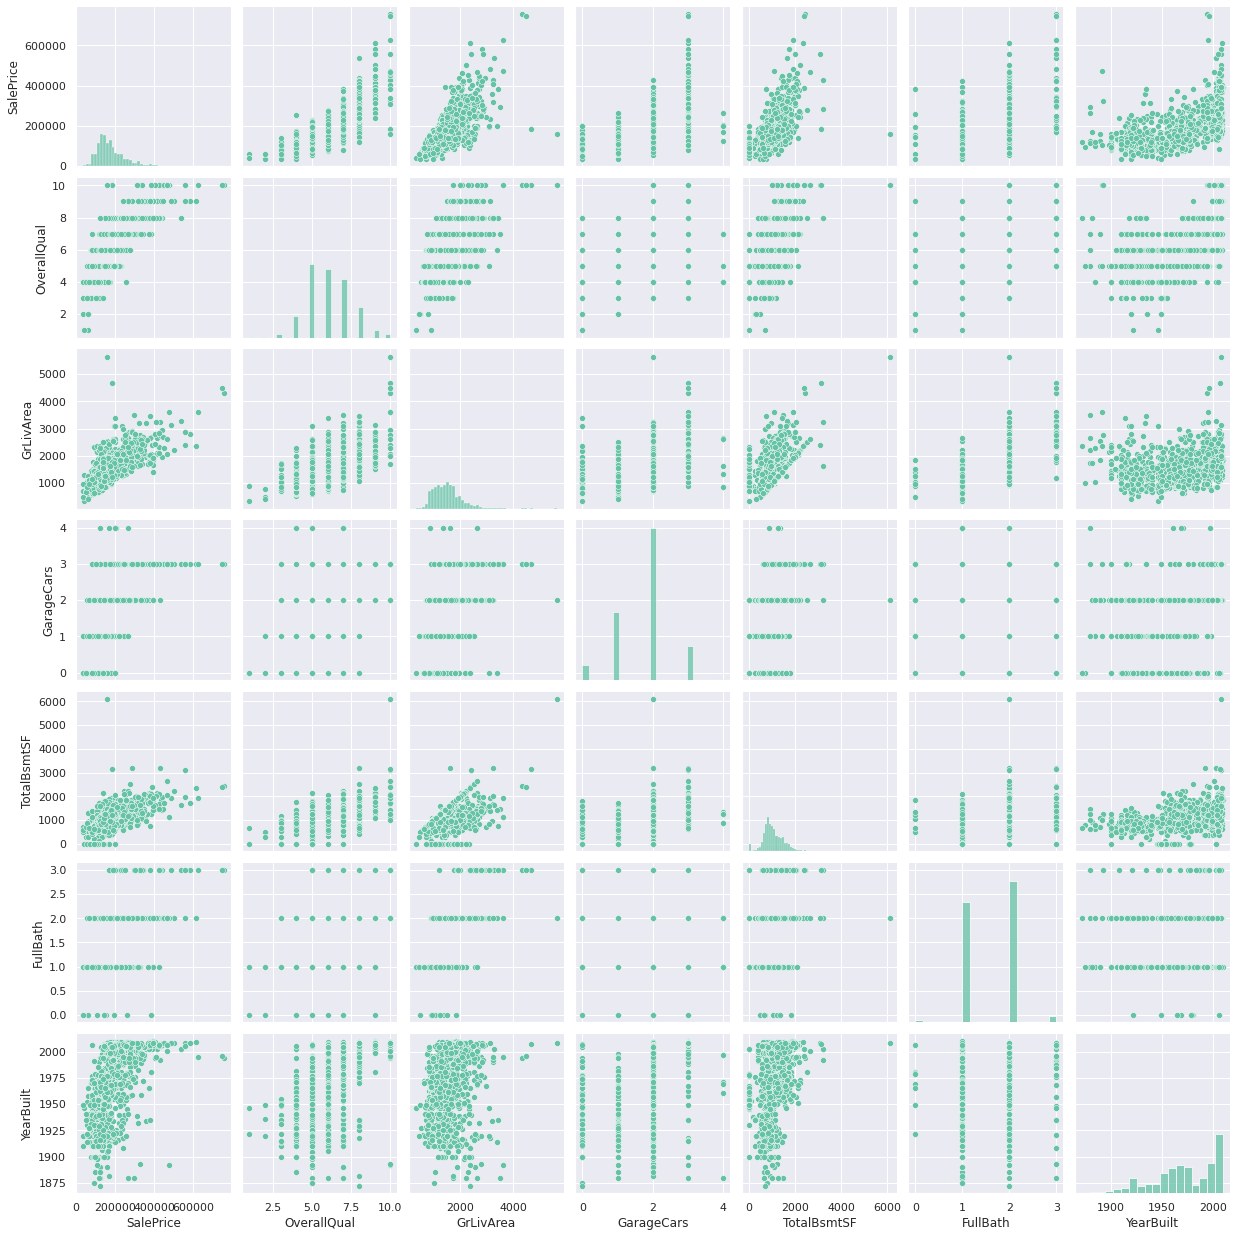

In [7]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])


## Missing values

In [8]:
def count_na(df):
    na_series = df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False)
    percentage = na_series / df.shape[0]
    miss_df = pd.concat([na_series, percentage], axis=1, keys=['Total', 'Ratio'])
    print(f'The number of features with NA: {len(na_series)}')
    return miss_df

In [9]:
count_na(train)

The number of features with NA: 19


,Total,Ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


In [10]:
count_na(test)

The number of features with NA: 33


,Total,Ratio
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageYrBlt,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461


### PoolQC, MiscFeature, Alley, Fence, FireplaceQu
According to description NA means the absence of the specified feature

In [11]:
for feat in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    train[feat].fillna('None', inplace=True)
    test[feat].fillna('None', inplace=True)

### LotFrontage
Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [12]:
train['LotFrontage'] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### GarageType, GarageFinish, GarageQual and GarageCond
Filling with None which means no garage

In [13]:
for feat in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[feat].fillna('None', inplace=True)
    test[feat].fillna('None', inplace=True)

### GarageYrBlt, GarageArea and GarageCars
Filling with 0 since no garage means no cars and etc.

In [14]:
for feat in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    train[feat].fillna(0, inplace=True)
    test[feat].fillna(0, inplace=True)

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2
NA means no basement

In [15]:
for feat in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train[feat].fillna('None', inplace=True)
    test[feat].fillna('None', inplace=True)

### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath
Since there is no basement we will replace NA with 0

In [16]:
for feat in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    train[feat].fillna(0, inplace=True)
    test[feat].fillna(0, inplace=True)

### MasVnrArea and MasVnrType
NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [17]:
train['MasVnrType'].fillna('None', inplace=True)
test['MasVnrType'].fillna('None', inplace=True)

train['MasVnrArea'].fillna(0, inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)

### MSZoning 
As this feature has only several missing values, we will fill it with mode - RL

In [18]:
test['MSZoning'].fillna(test.MSZoning.mode()[0], inplace=True)

### Utilities

In [19]:
train.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [20]:
test.Utilities.value_counts()

AllPub    1457
Name: Utilities, dtype: int64

Test set has constant feature, so it will be removed

In [21]:
train.drop('Utilities', axis=1, inplace=True)
test.drop('Utilities', axis=1, inplace=True)

### Functional
data description says NA means typical


In [22]:
test['Functional'].fillna('Typ', inplace=True)

### Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType 
These have only several NA value. We can set the mode for the missing value.

In [23]:
for feat in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    train[feat].fillna(train[feat].mode()[0], inplace=True)
    test[feat].fillna(test[feat].mode()[0], inplace=True)

### MSSubClass
Na most likely means No building class. We can replace missing values with None

In [24]:
test['MSSubClass'].fillna('None', inplace=True)

## Feature engineering

In [25]:
orders= {'ExterQual': ['Po', 'Fa','TA','Gd','Ex'], 'LotShape': ['Reg','IR1' ,'IR2','IR3'], 
         'BsmtQual': ['None', 'Po', 'Fa','TA','Gd','Ex'], 'BsmtCond': ['None','Po','Fa','TA','Gd','Ex'], 
         'BsmtExposure': ['None','No','Mn','Av','Gd'],'BsmtFinType1': ['None','Unf','LwQ', 'Rec','BLQ','ALQ', 'GLQ' ], 
         'BsmtFinType2': ['None','Unf','LwQ', 'Rec','BLQ','ALQ', 'GLQ' ], 'HeatingQC': ['Po','Fa','TA','Gd','Ex'],
         'Functional': ['Sal', 'Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'], 
         'FireplaceQu': ['None','Po','Fa','TA','Gd','Ex'], 'KitchenQual': ['Po', 'Fa','TA','Gd','Ex'], 
         'GarageFinish': ['None','Unf','RFn','Fin'], 'GarageQual': ['None','Po','Fa','TA','Gd','Ex'], 
         'GarageCond': ['None','Po','Fa','TA','Gd','Ex'], 'PoolQC': ['None','Fa', 'TA', 'Gd','Ex'], 
         'Fence': ['None','MnWw','GdWo','MnPrv','GdPrv']}

for field, order in orders.items(): 
    ord_enc = OrdinalEncoder(categories=[order]) 
    train[field] = ord_enc.fit_transform(train[[field]])
    test[field] = ord_enc.fit_transform(test[[field]])

In [26]:
for feat in ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']:
    train[feat] = LabelEncoder().fit_transform(train[feat])
    test[feat] = LabelEncoder().fit_transform(test[feat])

In [27]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,5,RL,65.0,8450,Pave,None,0.0,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,4,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3.0,TA,PConc,4.0,3.0,1.0,6.0,706,1.0,0,150,856,GasA,4.0,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,3.0,8,7.0,0,0.0,Attchd,2003.0,2.0,2,548,3.0,3.0,Y,0,61,0,0,0,0,0.0,0.0,None,0,1,2,WD,Normal,208500
1,2,0,RL,80.0,9600,Pave,None,0.0,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,7,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,2.0,TA,CBlock,4.0,3.0,4.0,5.0,978,1.0,0,284,1262,GasA,4.0,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,2.0,6,7.0,1,3.0,Attchd,1976.0,2.0,2,460,3.0,3.0,Y,298,0,0,0,0,0,0.0,0.0,None,0,4,1,WD,Normal,181500
2,3,5,RL,68.0,11250,Pave,None,1.0,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,4,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3.0,TA,PConc,4.0,3.0,2.0,6.0,486,1.0,0,434,920,GasA,4.0,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,3.0,6,7.0,1,3.0,Attchd,2001.0,2.0,2,608,3.0,3.0,Y,0,42,0,0,0,0,0.0,0.0,None,0,8,2,WD,Normal,223500
3,4,6,RL,60.0,9550,Pave,None,1.0,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,4,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2.0,TA,BrkTil,3.0,4.0,1.0,5.0,216,1.0,0,540,756,GasA,3.0,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,3.0,7,7.0,1,4.0,Detchd,1998.0,1.0,3,642,3.0,3.0,Y,0,35,272,0,0,0,0.0,0.0,None,0,1,0,WD,Abnorml,140000
4,5,5,RL,84.0,14260,Pave,None,1.0,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,4,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3.0,TA,PConc,4.0,3.0,3.0,6.0,655,1.0,0,490,1145,GasA,4.0,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,3.0,9,7.0,1,3.0,Attchd,2000.0,2.0,3,836,3.0,3.0,Y,192,84,0,0,0,0,0.0,0.0,None,0,11,2,WD,Normal,250000


## Outliers

In [28]:
def compute_skew(df):
    numeric_feats = df.dtypes[df.dtypes != 'object'].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew': skewed_feats})
    return skewness

In [29]:
skewness = compute_skew(train)
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.451640
PoolQC,16.834252
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186


In [30]:
skewness = skewness[abs(skewness.Skew) > 0.75]
print(f"There are {skewness.shape[0]} skewed numerical features to Box Cox transform")

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    if feat != 'Id':
        if feat == "SalePrice":
            train[feat] = np.log1p(train[feat])
        else:
            train[feat] = boxcox1p(train[feat], lam)
            test[feat] = boxcox1p(test[feat], lam)
        

There are 33 skewed numerical features to Box Cox transform


### GrLivArea

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

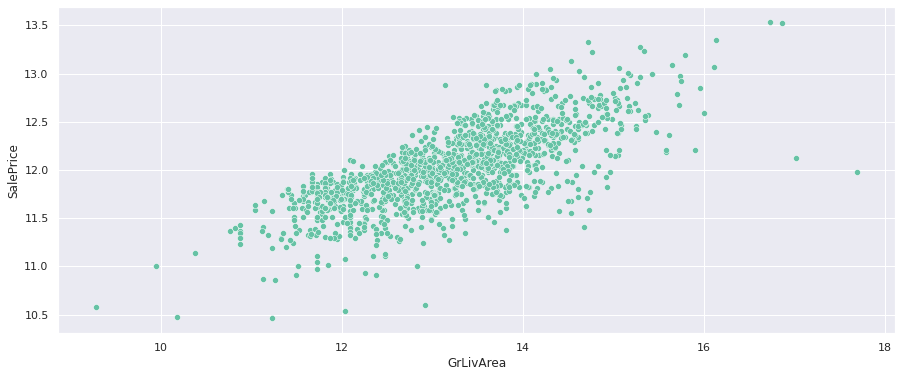

In [31]:
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')

In [32]:
train.sort_values(by='GrLivArea', ascending=False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,5,RL,9.125735,28.386046,Pave,None,1.540963,Bnk,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,4,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,11.493820,1.820334,TA,PConc,2.055642,1.540963,1.820334,6.0,17.69227,0.730463,0.0,10.094578,17.983825,GasA,4.0,Y,SBrkr,17.026675,11.981486,0.0,17.690976,2,0.0,2,1,3,0.730463,4.0,12,2.440268,3,4.0,Attchd,14.195323,3.0,2,1418,1.540963,1.540963,Y,8.253529,8.962610,0.0,0.0,0.0,10.169007,1.540963,0.0,None,0.0,0,2,New,Partial,11.982935
523,524,5,RL,7.184917,26.020123,Pave,None,0.730463,Bnk,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,4,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,11.375447,1.820334,TA,PConc,2.055642,1.540963,1.820334,6.0,14.56841,0.730463,0.0,11.762558,15.639628,GasA,4.0,Y,SBrkr,15.639628,13.377801,0.0,17.014541,1,0.0,3,1,3,0.730463,4.0,11,2.440268,1,4.0,BuiltIn,14.193765,3.0,3,884,1.540963,1.540963,Y,8.190318,9.752379,0.0,0.0,0.0,0.000000,0.000000,0.0,None,0.0,9,1,New,Partial,12.126764


### TotalBsmtSF

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

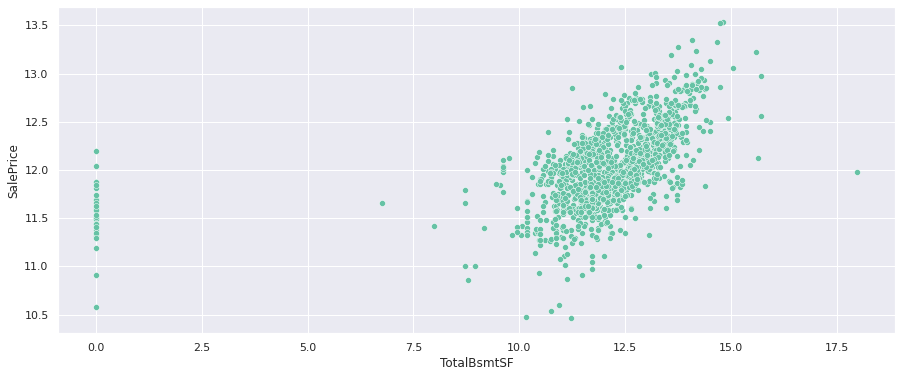

In [33]:
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')

In [34]:
train.sort_values(by='TotalBsmtSF', ascending=False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,5,RL,9.125735,28.386046,Pave,None,1.540963,Bnk,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,4,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,11.49382,1.820334,TA,PConc,2.055642,1.540963,1.820334,6.0,17.69227,0.730463,0.0,10.094578,17.983825,GasA,4.0,Y,SBrkr,17.026675,11.981486,0.0,17.690976,2,0.0,2,1,3,0.730463,4.0,12,2.440268,3,4.0,Attchd,14.195323,3.0,2,1418,1.540963,1.540963,Y,8.253529,8.96261,0.0,0.0,0.0,10.169007,1.540963,0.0,None,0.0,0,2,New,Partial,11.982935


In [35]:
train.drop(index=train.sort_values(by='GrLivArea', ascending=False)[:2].index.values, inplace=True)

In [36]:
print(train.shape)
print(test.shape)

(1458, 80)
(1459, 79)


In [37]:
ntrain = train.shape[0]

y_train = train.loc[:, 'SalePrice']
train.drop('SalePrice', axis=1, inplace=True)
full_data = pd.concat((train, test))
full_data = pd.get_dummies(full_data)
train = full_data[:ntrain]
test = full_data[ntrain:]

print(train.shape)
print(test.shape)

(1458, 232)
(1459, 232)


In [38]:
def explore_normality(feature):
    mu = train[feature].mean()
    sigma = train[feature].std()
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    y = norm.pdf(x, mu, sigma)
    norm_dist = pd.DataFrame({'x': x, 'y': y})

    fig, axes = plt.subplots(1, 2)
    sns.kdeplot(train[feature], ax=axes[0], label='Real dist')
    sns.lineplot(data=norm_dist, x='x', y='y', ax=axes[0], label='Normal dist')
    axes[0].legend()
    _=stats.probplot(train[feature], plot=plt)

# Modeling

In [39]:
X_train = train.drop("Id", axis=1)
X_test = test.drop("Id", axis=1)

In [40]:
GRID_SEARCH = False

## Lasso Regression

In [41]:
if GRID_SEARCH:

    lasso = make_pipeline(RobustScaler(), Lasso())

    param_grid = {
        'lasso__alpha': [0.0005, 0.005, 0.05, 0.5, 1],
        'lasso__fit_intercept': [True, False]
    }

    gs = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                      n_jobs=-1, cv=5, refit=True)
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    print(-gs.best_score_)

In [42]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.005))

## Elastic Net Regression

In [43]:
if GRID_SEARCH:
    enet = make_pipeline(RobustScaler(), ElasticNet())

    param_grid = {
        'elasticnet__alpha': [0.0005, 0.005, 0.05, 0.5, 1],
        'elasticnet__fit_intercept': [True, False],
        'elasticnet__l1_ratio': np.arange(0.1, 1.1, 0.1)
    }

    gs = GridSearchCV(estimator=enet, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                      n_jobs=-1, cv=5, refit=True)
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    print(-gs.best_score_)

In [44]:
enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.005, l1_ratio=0.5))

## Kernel Ridge Regression

In [45]:
if GRID_SEARCH:
    ridge = KernelRidge()

    param_grid = {
        'alpha': np.arange(0.1, 1.1, 0.1),
        'kernel': ['polynomial'],
        'coef0': np.arange(0.5, 5.5, 0.5),
        'degree': [2, 3]
        
    }

    gs = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                      n_jobs=-1, cv=5, refit=True)
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    print(-gs.best_score_)

In [46]:
KRR = KernelRidge(alpha=0.9, coef0=3.0, degree=2, kernel='polynomial')

## Gradient Boosting Regression

In [47]:
if GRID_SEARCH:
    gboost = GradientBoostingRegressor()

    param_grid = {
        'n_estimators': np.arange(1000, 6000, 1000),
        'learning_rate': [0.0005, 0.005, 0.05, 0.5],
        'max_depth': [3, 4, 5, 6, 7],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [5, 10, 15, 20],
        'min_samples_leaf': [5, 10, 15, 20],
        'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']
        
    }

    gs = RandomizedSearchCV(estimator=gboost, param_distributions=param_grid, scoring='neg_root_mean_squared_error',
                            n_jobs=-1, cv=5, refit=True, n_iter=50)
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    print(-gs.best_score_)

In [48]:
gboost = GradientBoostingRegressor(n_estimators=5000, min_samples_leaf=5, max_features='sqrt',
                                   max_depth=3, loss='huber', learning_rate=0.005)

## XGBoost

In [49]:

if GRID_SEARCH:
    xgboost = xgb.XGBRegressor(verbosity=3)

    param_grid = {
        'n_estimators': np.arange(1000, 4000, 1000),
        'learning_rate': [0.0005, 0.005, 0.05, 0.5],
        'max_depth': [3, 4, 5],
        'n_jobs': [-1],
        'gamma': [0.005, 0.05],
        'min_child_weight': [1.5, 2, 2.5],
        'subsample': np.arange(0.5, 0.7, 0.1),
        'reg_alpha': np.arange(0.1, 1, 0.1),
        'reg_lambda': np.arange(0.1, 1, 0.1)
        
    }

    gs = RandomizedSearchCV(estimator=xgboost, param_distributions=param_grid, scoring='neg_root_mean_squared_error',
                            n_jobs=-1, cv=5, refit=True, n_iter=10, verbose=10)
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    print(-gs.best_score_)

In [50]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state =7, n_jobs = -1)

## LightGBM 

In [51]:
if GRID_SEARCH:
    xgboost = lgb.LGBMRegressor(n_jobs=-1, objective='Regression')

    param_grid = {
        'n_estimators': np.arange(500, 4500, 1000),
        'learning_rate': [0.0005, 0.005, 0.05, 0.5],
        'reg_alpha': np.arange(0.1, 1, 0.1),
        'reg_lambda': np.arange(0.1, 1, 0.1),
        'num_leaves': [5, 10, 20, 30],
        'max_depth': [-1, 5, 10, 15]
    }

    gs = RandomizedSearchCV(estimator=xgboost, param_distributions=param_grid, scoring='neg_root_mean_squared_error',
                            n_jobs=-1, cv=5, refit=True, n_iter=50, verbose=10)
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    print(-gs.best_score_)

In [52]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720)

## Models perfomance

In [53]:
def save_submission(preds, name):
    output = pd.DataFrame({"Id": test.Id, "SalePrice": preds})
    output.to_csv('Submission_' + name + '.csv', index=False)

In [54]:
#Validation function
NFOLDS = 5

def cross_val(model):
    kf = KFold(NFOLDS, shuffle=True, random_state=42).get_n_splits(train)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train.values, scoring="neg_mean_squared_error", cv=kf))
    return rmse.mean(), rmse.std()

In [55]:
model_names = ['Lasso', 'ElasticNet', 'KernelRidge', 'GB', 'XGB', 'LGBM']
cv_results = pd.DataFrame(index=["RMSE mean", "RMSE std"])

for i, model in enumerate([lasso, enet, KRR, gboost, model_xgb, model_lgb]):
    cv_results[model_names[i]] = cross_val(model)
    preds = np.expm1(model.fit(X_train, y_train).predict(X_test))
    save_submission(preds, model_names[i])
cv_results

,Lasso,ElasticNet,KernelRidge,GB,XGB,LGBM
RMSE mean,0.125443,0.121134,0.141853,0.110243,0.115969,0.118264
RMSE std,0.006568,0.006779,0.008083,0.006297,0.007335,0.005094


## VotingRegressor

In [56]:
model_names = ['KernelRidge', 'GB', 'XGB', 'LGBM']
models = [KRR, gboost, model_xgb, model_lgb]
voting_format = [(name, model) for name, model in zip(model_names, models)]
voting = VotingRegressor(voting_format)

cv_results['Voting'] = cross_val(voting)

preds = np.expm1(voting.fit(X_train, y_train).predict(X_test))
save_submission(preds, 'Voting')

## Stacking Regressor

In [57]:
model_names = ['Lasso', 'ElasticNet', 'GB', 'XGB', 'LGBM']
models = [lasso, enet, gboost, model_xgb, model_lgb]
stacking_format = [(name, model) for name, model in zip(model_names, models)]

stack = StackingRegressor(estimators=stacking_format, cv=5, n_jobs=-1)
stack.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('Lasso',
                               Pipeline(steps=[('robustscaler', RobustScaler()),
                                               ('lasso', Lasso(alpha=0.005))])),
                              ('ElasticNet',
                               Pipeline(steps=[('robustscaler', RobustScaler()),
                                               ('elasticnet',
                                                ElasticNet(alpha=0.005))])),
                              ('GB',
                               GradientBoostingRegressor(learning_rate=0.005,
                                                         loss='huber',
                                                         max_features='sqrt',
                                                         min_samples_leaf=5,
                                                         n_estimators=5000)...
                                            max_cat_to_onehot=4,
                        

In [58]:
cv_results['Stacking'] = cross_val(stack)
preds = np.expm1(stack.predict(X_test))
save_submission(preds, 'Stacking')

cv_results

,Lasso,ElasticNet,KernelRidge,GB,XGB,LGBM,Voting,Stacking
RMSE mean,0.125443,0.121134,0.141853,0.110243,0.115969,0.118264,0.111189,0.108405
RMSE std,0.006568,0.006779,0.008083,0.006297,0.007335,0.005094,0.005804,0.005594


## Voting Weights

In [59]:
model_names = ['Stacking', 'GB', 'XGB', 'LGBM']
models = [stack, gboost, model_xgb, model_lgb]
voting_format = [(name, model) for name, model in zip(model_names, models)]
voting_w = VotingRegressor(voting_format, weights=[0.5, 0.3, 0.1, 0.1])

cv_results['VotingWeights'] = cross_val(voting_w)

preds = np.expm1(voting_w.fit(X_train, y_train).predict(X_test))
save_submission(preds, 'VotingWeights')

In [60]:
cv_results

,Lasso,ElasticNet,KernelRidge,GB,XGB,LGBM,Voting,Stacking,VotingWeights
RMSE mean,0.125443,0.121134,0.141853,0.110243,0.115969,0.118264,0.111189,0.108405,0.108822
RMSE std,0.006568,0.006779,0.008083,0.006297,0.007335,0.005094,0.005804,0.005594,0.006368
